# Flight Performance in US 

## Investigation Overview

The goal of the investigation is to tinker more with the flight performance data to understand the responsible factors causing flight delays as well as present carrier performance in terms of cancellations and delays.

## Dataset Overview

The dataset has been collected from Bureau of Transportation Statistics. It contains information about delays and cancellations for different carriers and destinations. This dataset has been retrieved from their official website in CSV format.The whole statistical dataset has been downloaded for two years; 2007 and 2008.

In [1]:
#importing all libraries needed 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import requests
import matplotlib.patches as mpatches
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures 

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
df_2008 = pd.read_csv('2008.csv')
df_2007 = pd.read_csv('2007.csv')

# #appending the dataset 
df_data=df_2007.append([df_2008])

#df_data.to_csv('final.csv') 

#reading the final.csv (as i saved the data as final.csv)

df = pd.read_csv('final.csv')

In [3]:
#shape of the dataset 
df.shape

(9842432, 30)

In [4]:
# dataset cleaning, removing uncessary column
df.drop(["Unnamed: 0"], axis='columns', inplace=True)
#df.head()

### What are the biggest reasons for cancellations?
Carrier and weather related cancellations are most common.

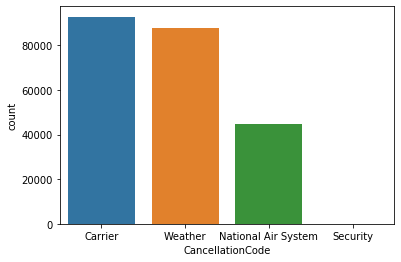

In [5]:
#Define plot (reference: http://alanpryorjr.com/visualizations/seaborn/countplot/countplot/)
plot = sb.countplot(x="CancellationCode", data=df)
plot.set_xticklabels(['Carrier','Weather','National Air System','Security']);

## Which carrier had the most cancellations?

Envoy Air (MQ) and American Airlines (AA) performed the worst in terms of cancellations. Envoy Air is at the top in case of carrier cancellations which was followed by American Airlines and Skywest Airlines.

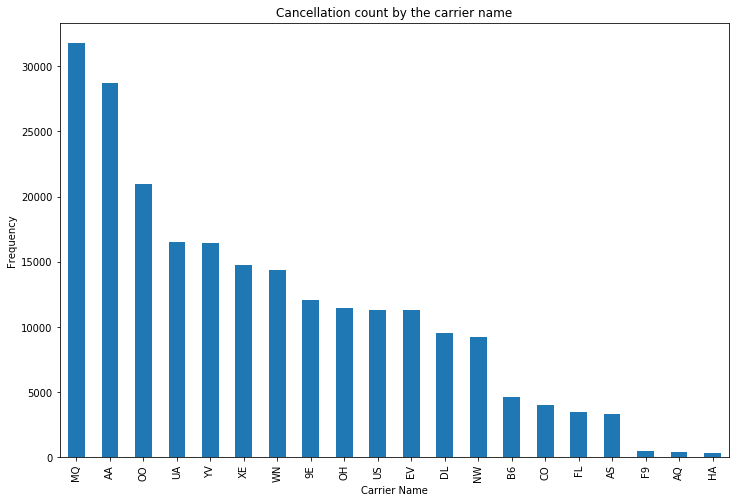

In [6]:
# creating a DataFrame with carrier and cancellation code 
carrier = df.UniqueCarrier.tolist()
cancellation_code = df.CancellationCode.tolist()

most_cancellation = pd.DataFrame({'cancellation_code':cancellation_code, 'carrier': carrier})
most_cancellation = most_cancellation.dropna()
#most_cancellation

#Define Plot
plt.figure(figsize=(12,8))
fig= most_cancellation['carrier'].value_counts().plot(kind ='bar')
fig.set_title('Cancellation count by the carrier name')
fig.set_xlabel('Carrier Name')
fig.set_ylabel('Frequency');

## What about delays? Did the same carriers also perform bad in terms of delays? (Arrival and Departure) 

It's pretty interesting that, American Airlines also performed worse in arrival delays. And MQ (Envoy Airlines) secured the third position in most delayed occurance. From the plot it is also observable that 'WN' has the highest Departure Delay.

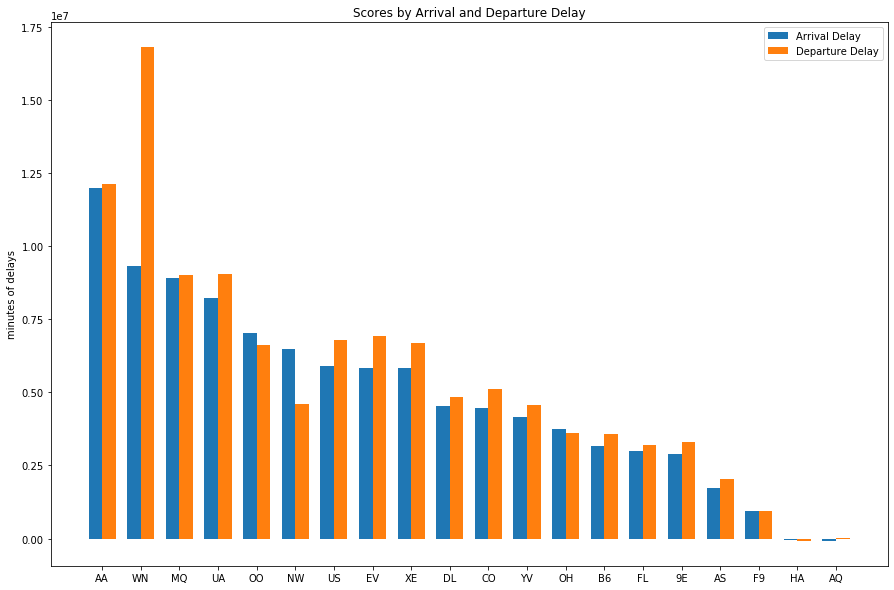

In [7]:
#To explore delays, we created new dataframes that excluded NaN (missing) values in delays to plot histogram.
arrival_delay = df[df.ArrDelay.notnull()]
departure_delay = df[df.DepDelay.notnull()]

# grouping the arrival and departure by Carrier
arrival_delay_carrier = arrival_delay.groupby('UniqueCarrier').ArrDelay.sum().sort_values(ascending=False)
departure_delay_carrier = departure_delay.groupby('UniqueCarrier').DepDelay.sum().sort_values(ascending=False)
delay=pd.merge(arrival_delay_carrier,departure_delay_carrier,on='UniqueCarrier')
# delay.head()

#Define Plot
x = np.arange(len(delay.index))  # the carrier locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 10))
rects1 = ax.bar(x - width/2, delay.ArrDelay, width, label='Arrival Delay')
rects2 = ax.bar(x + width/2, delay.DepDelay, width, label='Departure Delay')

# Adding some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('minutes of delays')
ax.set_title('Scores by Arrival and Departure Delay')
ax.set_xticks(x)
ax.set_xticklabels(delay.index)
ax.legend()
plt.show();

## What is the Fight performance of the carriers in terms of arrival delays? 

It is visible that the carrier 'WN' has conducted more flights and they have the highest number of delays as well and the next plot reveals that the highest percentage of delays has been occured in the carrier named 'NW'.

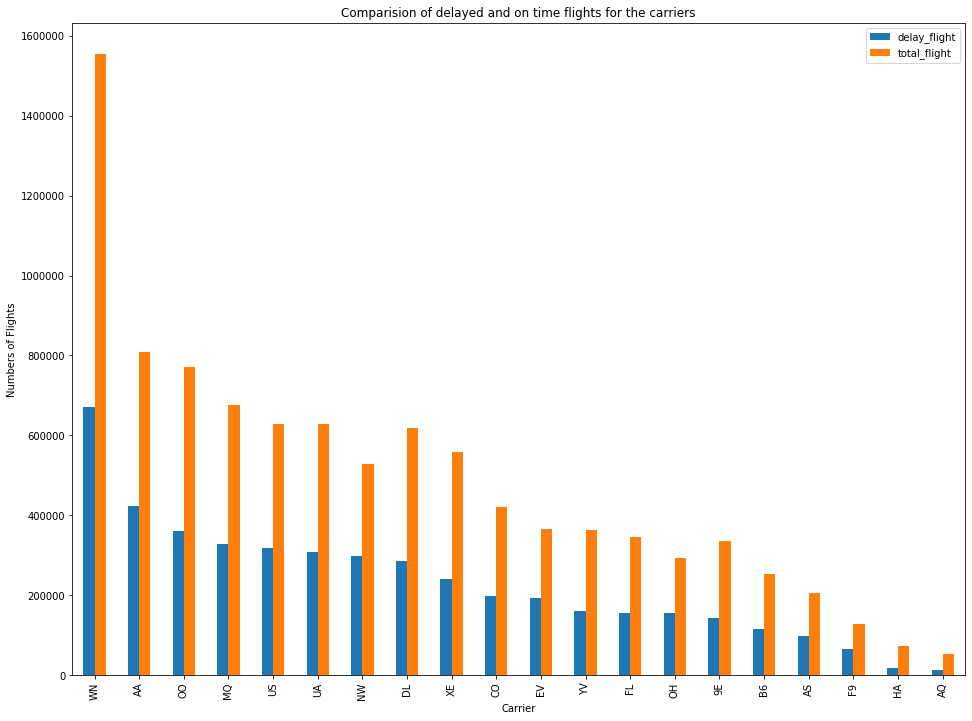

In [8]:
#Getting a dataframe with number of flights that were delayed and not cancelled by each carrier
df_depart_delay=df[df.DepDelay.notnull()]
arrival_delayed=df_depart_delay.query('Cancelled==0 & ArrDelay>0').groupby('UniqueCarrier').size().reset_index(name='delayed_flights')

#arrival_delayed.head()

#Getting a dataframe with number of total flights that took off (not cancelled)
uncancelled_flights=df.query('Cancelled==0').groupby('UniqueCarrier').size().reset_index(name='total_flights')
#uncancelled_flights.head()

#Merging both dataframes on unique_carrier_code
df_merged=pd.merge(arrival_delayed,uncancelled_flights,on='UniqueCarrier')
df_merged = df_merged.sort_values(by =['delayed_flights', 'total_flights'], ascending = False)
#df_merged.head()

# changing the index as carrier 
carrier = df_merged.UniqueCarrier.tolist()
delay_flight = df_merged.delayed_flights.tolist()
total_flight = df_merged.total_flights.tolist()

df1 = pd.DataFrame({'delay_flight':delay_flight, 'total_flight':total_flight}, index = carrier)
# df1['ratio']=df1.delay_flight/df1.total_flight
#df1.head()

# Define plot 
ax = df1.plot.bar(figsize= [16,12], rot=90)
plt.xlabel('Carrier')
plt.ylabel('Numbers of Flights')
plt.title('Comparision of delayed and on time flights for the carriers')

plt.show()

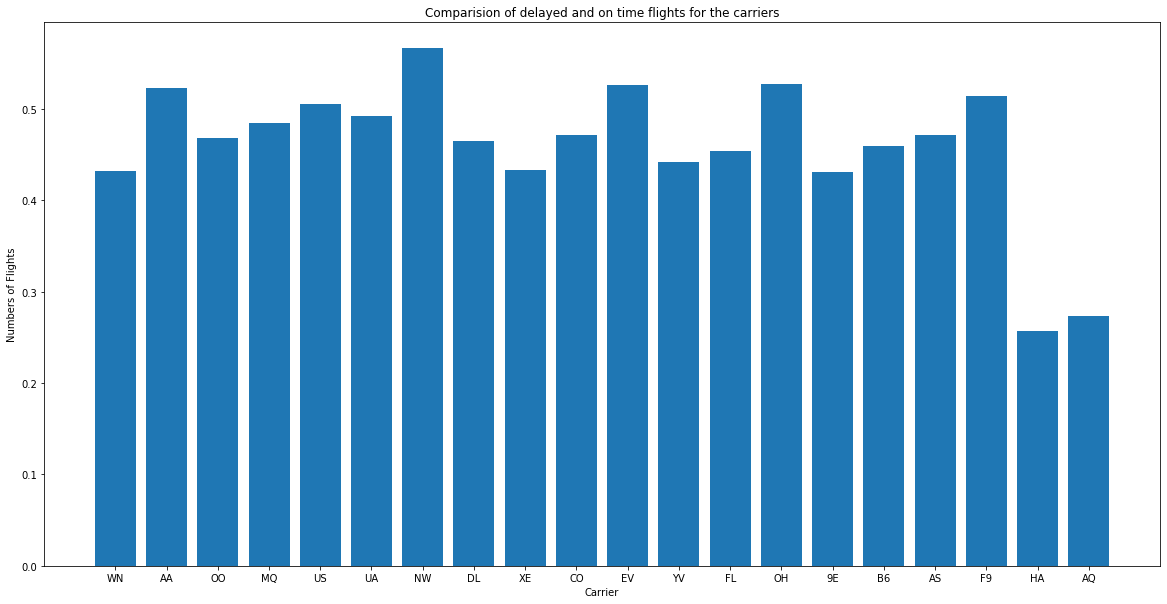

In [9]:
df1['ratio']=df1.delay_flight/df1.total_flight
df1

# Define plot 
plt.figure(figsize=(20,10))
plt.bar(list(df1.index), df1.ratio)
plt.xlabel('Carrier')
plt.ylabel('Numbers of Flights')
plt.title('Comparision of delayed and on time flights for the carriers')

plt.show()

### Is there any relationship between the flight delays and destination ?

The overview of top 20 Desitinations has been provided where the flights has conducted on Time and delayed. The highest number of flight has been conducted in 'ATL'(Atlanta, GA: Hartsfield-Jackson Atlanta International) and the delayed number of flights is also higher in 'ATL'. It's pretty interesting all the destinations has a delayed number flights which is almost the half the number of total flights conducted for respective destinations.

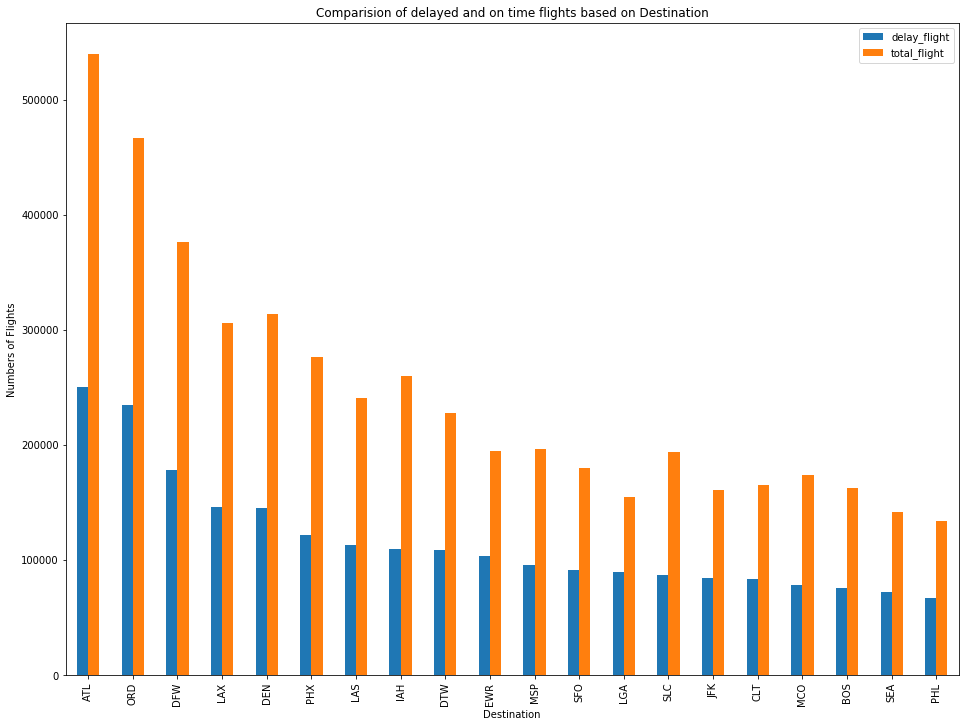

In [10]:
# getting information for destination based flights that has delayed but not cancelled 
df_depart_delay=df[df.DepDelay.notnull()]
arrival_delayed_dest=df_depart_delay.query('Cancelled==0 & ArrDelay>0').groupby('Dest').size().reset_index(name='delayed_flights')

#arrival_delayed_dest.head()

#Getting a dataframe with number of total flights that took off (not cancelled) based on destination 
uncancelled_flights_dest=df.query('Cancelled==0').groupby('Dest').size().reset_index(name='total_flights')
#uncancelled_flights_dest.head()

#Merging both dataframes on Destination 
df_merged_dest=pd.merge(arrival_delayed_dest,uncancelled_flights_dest,on='Dest')
#df_merged_dest.head()

df_merged_dest_sort = df_merged_dest.sort_values(by =['delayed_flights', 'total_flights'], ascending = False)
top_20_destination = df_merged_dest_sort.head(20)

# changing the index as Destination 
dest = top_20_destination.Dest.tolist()
delay_flight = top_20_destination.delayed_flights.tolist()
total_flight = top_20_destination.total_flights.tolist()

df2 = pd.DataFrame({'delay_flight':delay_flight, 'total_flight':total_flight}, index = dest)
df2.head()
# Define Plot 
ax = df2.plot.bar(figsize= [16,12], rot=90)
plt.xlabel('Destination')
plt.ylabel('Numbers of Flights')
plt.title('Comparision of delayed and on time flights based on Destination')

plt.show()

### Is there any relations between the AirTime and the flight delays? Are long distance flights prone delay more than that of small distance Flights while conducting Flights ? [long/small distance flights(in time)]  

Because of some outliers the regression line has gone up suddenly. But, the delays are in gerneral acute in those flights where the AirTime is less and delays decreases as the AirTime increases. 
The comparision between the regression line for carrier delay and carrier delay with respect to the AirTime has observed. The delays are more acute in the flights where the AirTime is less.i.e. the figure for the carrier delay. Other delays can be compared with regression line as well. 

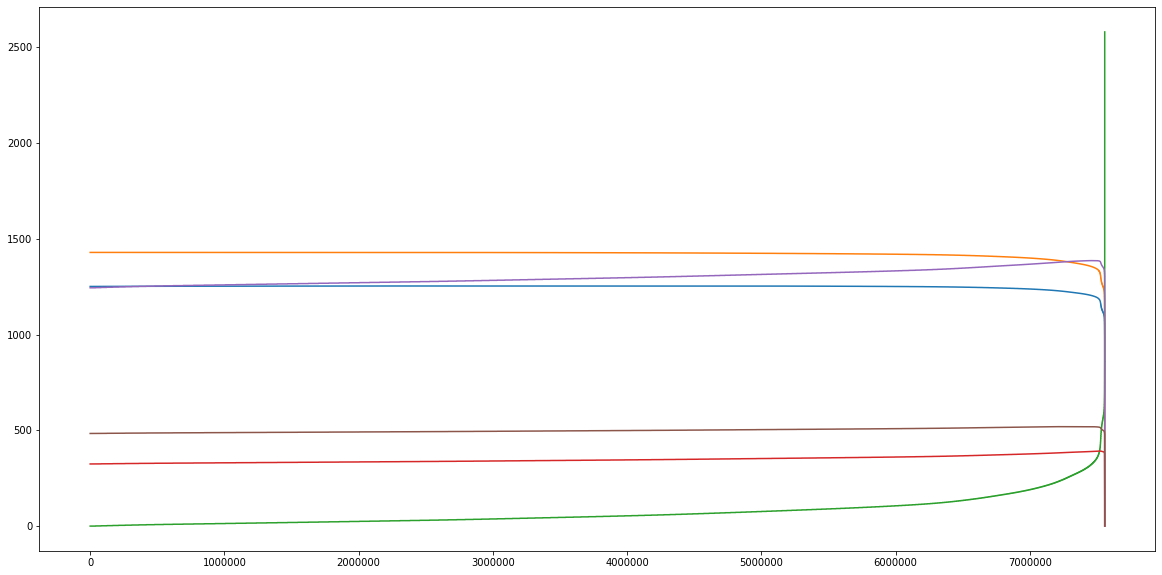

In [11]:
#creating arrays for the necessary columns 
data = {'AirTime':df.AirTime,'CD':df.CarrierDelay,'WD':df.WeatherDelay, 'NASD':df.NASDelay, 'SD':df.SecurityDelay, 'LAD':df.LateAircraftDelay}

# creating dataframe with all the delays and AirTime 
df3=pd.DataFrame(data)

#droping null values 
df3 = df3.dropna()

#dropping flights having less airtime than 30, for generating good graph
df3 = df3.drop(df3[df3.AirTime < 30.0].index)

#sorting 
df3 = df3.sort_values(by=['AirTime'])

df3['MeanDelay'] = df3.loc[:,'CD':].mean(axis=1)
df3 = df3.astype('float32')
#df3

# defining a function for polynomial regression (for each delay)
def polyreg(data):
    poly = PolynomialFeatures(degree = 2) 
    X_poly = poly.fit_transform(np.array(df3.AirTime).reshape(-1, 1)) 

    poly.fit(X_poly, np.array(data)) 
    lin2 = LinearRegression() 
    lin2.fit(X_poly, np.array(data)) 

    reg = lin2.predict(poly.fit_transform(np.array(df3.AirTime).reshape(-1, 1)))
    scale = (reg*(min(data)-max(data))-max(reg)*min(data)+min(reg)*max(data))/(min(reg)-max(reg))
    return scale

# inserting every delays in the function 
lad= polyreg(df3.LAD)
wd= polyreg(df3.WD)
cd= polyreg(df3.CD)
sd= polyreg(df3.SD)
nasd= polyreg(df3.NASD)
md= polyreg(df3.MeanDelay)

#Define Plot (regression plot for the delays)
plt.figure(figsize=(20,10))
plt.plot(lad)
plt.plot(wd)
plt.plot(cd)
plt.plot(sd)
plt.plot(nasd)
plt.plot(md)
#plt.plot(df3.AirTime*(len(scaled)/max(exp)),exp)

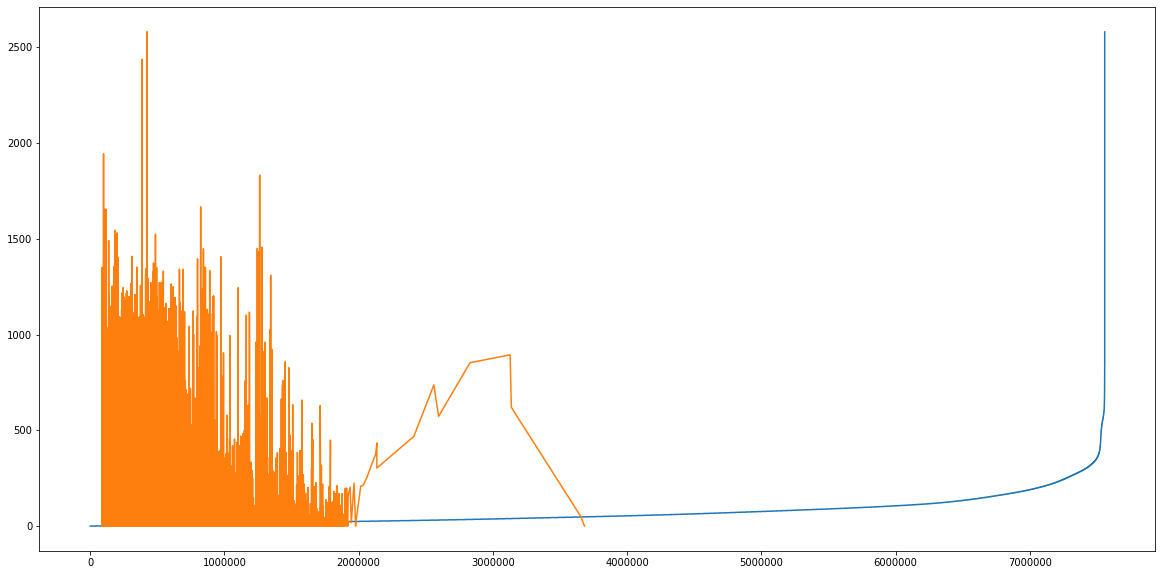

In [12]:
# Define Plot (original Carrier delay vs the regression line for Carrier Delay)
plt.figure(figsize=(20,10))
plt.plot(cd)
plt.plot(df3.AirTime*(len(cd)/max(df3.CD)),df3.CD)

## Summary and Conclusion

** Carrier and weather related cancellations were mostly observed in this investigation. 

** American Airlines performed the worst in terms of both delays and cancellations.

** WN as a carrier has conducted more Flights adn the percentage of delay is also high in terms of total number of flights. 

** AS AirTime increases the possibility of delays decreases (according to regression line).